In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from pyreadr import read_r
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform, lognorm, chi2, t

if '__file__' in globals():
    PROJECT_PATH = Path(__file__).parent.resolve()
else:
    PROJECT_PATH = Path(globals()['_dh'][0])

Načtěte datový soubor a rozdělte sledovanou proměnnou na příslušné dvě pozorované skupiny.

In [2]:
data: pd.DataFrame = read_r(PROJECT_PATH / 'case0301.rda')['case0301']  # type: ignore
seeded: pd.DataFrame = data.loc[data['Treatment'] == 'Seeded', ['Rainfall']]
unseeded: pd.DataFrame = data.loc[data['Treatment'] == 'Unseeded', ['Rainfall']]
cd = {
    'seeded': seeded['Rainfall'],
    'unseeded': unseeded['Rainfall'],
}

x_all = sorted(data['Rainfall'])

Stručně popište data a zkoumaný problém.

In [3]:
data.__doc__ = """Data popisujú množstvo zrážok(Objem/ft²),
ktoré spadne pri zhadzovaní a bez zhadzovania Iodidu strieborného na mračná.
Úlohou je zistiť či tento proces zvyšuje množstvo zrážok. """

Pro každou skupinu zvlášť odhadněte střední hodnotu, rozptyl a medián příslušného rozdělení.

In [4]:
mean = {k: v.mean() for k, v in cd.items()}
var = {k: v.var() for k, v in cd.items()}
median = {k: v.median() for k, v in cd.items()}

print(f'{mean=}')
print(f'{var=}')
print(f'{median=}')

mean={'seeded': np.float64(441.9846234871791), 'unseeded': np.float64(164.58845985852756)}
var={'seeded': np.float64(423523.9649790639), 'unseeded': np.float64(77521.25946156685)}
median={'seeded': np.float64(221.5999984741211), 'unseeded': np.float64(44.19999885559082)}


Pro každou skupinu zvlášť odhadněte hustotu a distribuční funkci pomocí histogramu a empirické distribuční funkce.

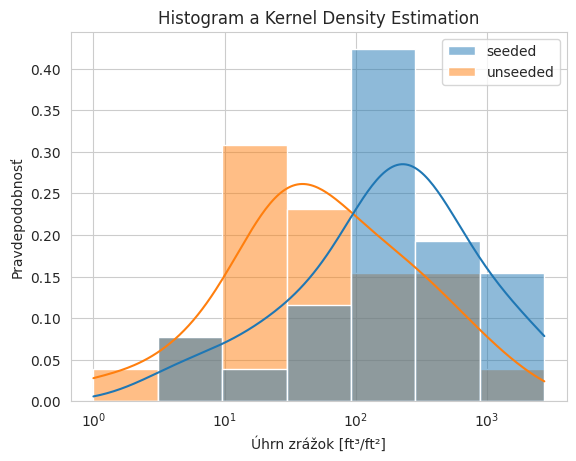

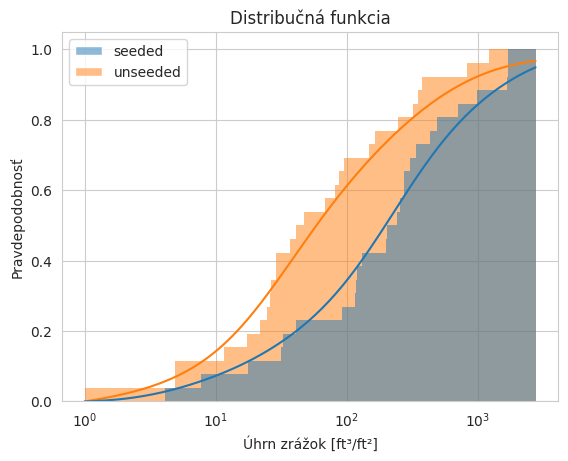

In [5]:
ax = sns.histplot(
    cd,
    stat='probability',
    bins='fd',
    common_norm=False,
    log_scale=10,
    kde=True,
    multiple='layer',
)
ax.set(
    title='Histogram a Kernel Density Estimation',
    xlabel='Úhrn zrážok [ft³/ft²]',
    ylabel='Pravdepodobnosť',
)
plt.show()

ax = sns.histplot(
    cd,
    stat='probability',
    bins=np.log10(x_all),
    common_norm=False,
    log_scale=10,
    kde=True,
    multiple='layer',
    cumulative=True,
)
ax.set(
    title='Distribučná funkcia',
    xlabel='Úhrn zrážok [ft³/ft²]',
    ylabel='Pravdepodobnosť'
)
plt.show()

Pro každou skupinu zvlášť najděte nejbližší rozdělení:
1) Odhadněte parametry normálního, exponenciálního a rovnoměrného rozdělení. (+ LogNormal)
2) Zaneste příslušné hustoty s odhadnutými parametry do grafů histogramu.
3) Diskutujte, které z rozdělení odpovídá pozorovaným datům nejlépe.


In [6]:

# for most distribution we want to fix loc parameter as 
# negative volume of rain does not make sense, but no rain should be possible
distributions = {
    'normal': (norm, {}),
    'exponential': (expon, {'floc': 0}),
    'uniform': (uniform, {}),
    'log normal': (lognorm, {'floc': 0}),  # comment out if you don't want to use log-normal
}

Category: seeded
	normal: (np.float64(441.9846234871791), np.float64(638.1493412287114))
	exponential: (0.0, 441.9846234871791)
	uniform: (4.099999904632568, 2741.5000977516174)
	log normal: (np.float64(1.5684521470222774), 0, np.float64(169.72624115270025))


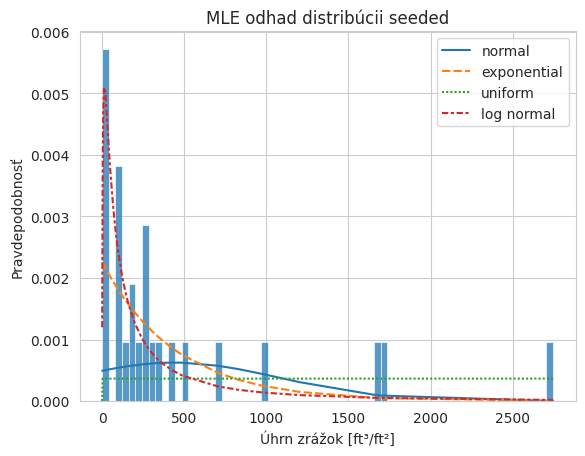

Category: unseeded
	normal: (np.float64(164.58845985852756), np.float64(273.0195461119934))
	exponential: (0.0, 164.58845985852756)
	uniform: (1.0, 1201.5999755859375)
	log normal: (np.float64(1.6099639062265794), 0, np.float64(54.07682009467271))


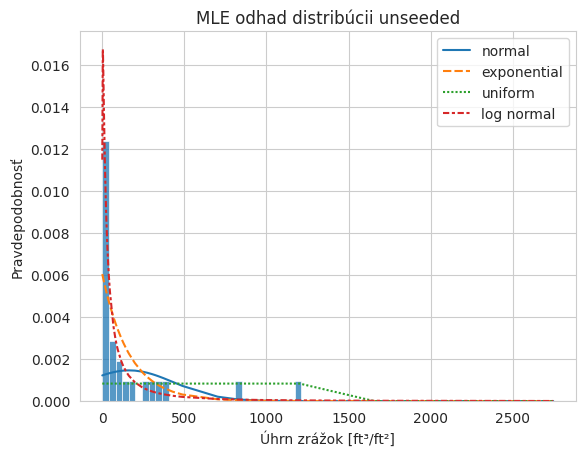

In [7]:
bins = np.histogram_bin_edges(x_all, bins='stone')  # bins computed from all samples
for category, cat_data in cd.items():
    print('Category:', category)
    # bins = np.histogram_bin_edges(cat_data, bins='stone')    
    fitted = pd.DataFrame(index=x_all)
    for name, (dist, kw) in distributions.items():
        param = dist.fit(cat_data, **kw)
        fitted[name] = dist.pdf(x_all, *param)
        print(f'\t{name}: {param}')
        
    ax = sns.histplot(cat_data, stat='density', bins=bins)
    sns.lineplot(fitted)
    ax.set(
        title=f'MLE odhad distribúcii {category}',
        ylabel='Pravdepodobnosť',
        xlabel='Úhrn zrážok [ft³/ft²]'
    )
    plt.show()

Z vynesených grafou vyzerá log-normál ako najpresnejšie rozdelenie. Druhé najlepšie vyzerá byť exponenciálne rozdelenie.

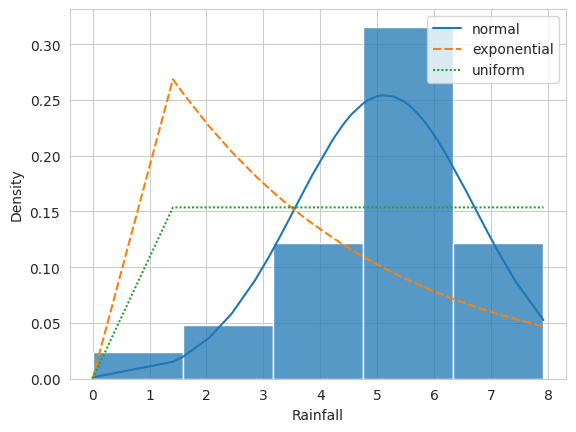

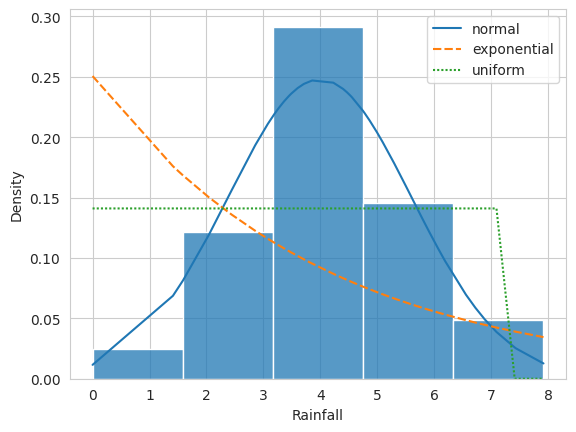

In [8]:
# To isté ale zrážky sú zlogaritmované.
x_all_log = np.log(x_all)
cd_log = {cat: np.log(d) for cat, d in cd.items()}

bins = np.histogram_bin_edges(x_all_log, bins='stone')
for category, cat_data in cd_log.items():
    # bins = np.histogram_bin_edges(cat_data, bins='stone')    
    fitted = pd.DataFrame(index=x_all_log)
    for name, (dist, _) in distributions.items():
        if name == 'log normal':  # nepotrebujeme loglog normal
            continue
        param = dist.fit(cat_data)
        fitted[name] = dist.pdf(x_all_log, *param)
        
    sns.histplot(cat_data, stat='density', bins=bins)
    sns.lineplot(fitted)
    plt.show()

In [9]:
def nllf(distribution, sample, parameters=None, **kwargs):
    """Negative log likelihood function."""
    if parameters is None:
        parameters = distribution.fit(sample, **kwargs)
    return -np.sum(np.log(distribution.pdf(sample, *parameters)))

sample_nllf = {dist_name: 0 for dist_name in distributions}
for cat_name, cat_data in cd.items():
    print(f'{cat_name}:')
    for d_name, (dist, kw) in distributions.items():
        c_nllf = nllf(dist, cat_data, **kw)
        print(f'\t{d_name}: nllf={c_nllf}')
        sample_nllf[d_name] += c_nllf

best_distribution_name = min(sample_nllf, key=sample_nllf.get)
best_distribution, bkw = distributions[best_distribution_name]
print('best_distribution:', best_distribution_name)

seeded:
	normal: nllf=204.81528252428538
	exponential: nllf=184.3731524175325
	uniform: nllf=205.82277379300922
	log normal: nllf=182.0835787036332
unseeded:
	normal: nllf=182.7405300059686
	exponential: nllf=158.68965256481027
	uniform: nllf=184.37664077798962
	log normal: nllf=153.02445400939618
best_distribution: log normal


Pro každou skupinu zvlášť vygenerujte náhodný výběr o 100 hodnotách z rozdělení, které jste zvolili jako nejbližší, s parametry odhadnutými v předchozím bodě. Porovnejte histogram simulovaných hodnot s pozorovanými daty.

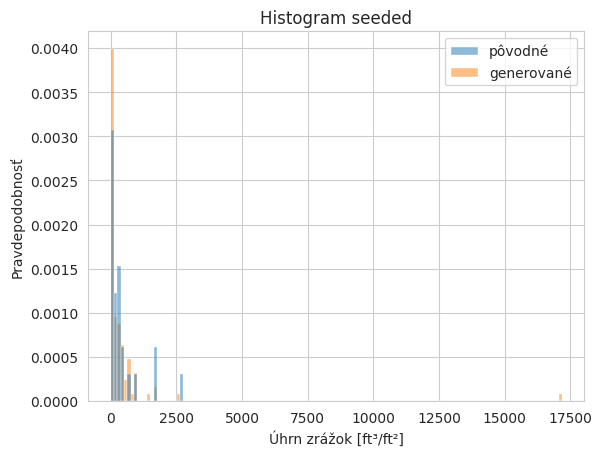

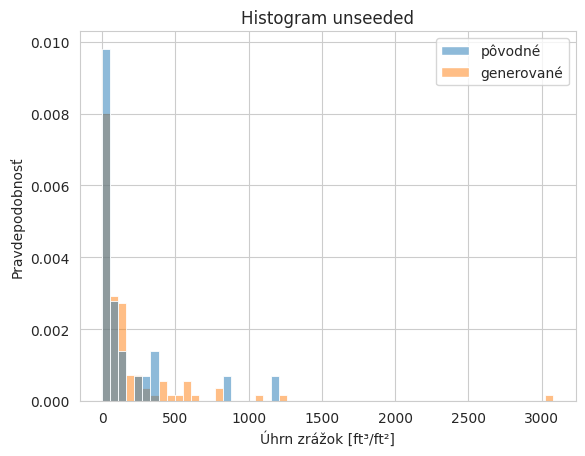

In [10]:
dist_parameters = {
    cat: best_distribution.fit(d, **bkw) for cat, d in cd.items()
}

N = 100
bootstrap = {
    cat: best_distribution.rvs(*param, size=N)
            for cat, param in dist_parameters.items()
}

bins = np.histogram_bin_edges(x_all, bins='stone')
for cat, original in cd.items():
    sampled = bootstrap[cat]
    
    ax = sns.histplot(
        {
            'pôvodné': original,
            'generované': sampled,
        },
        stat='density',
        common_norm=False
    )
    ax.set(
        title=f'Histogram {cat}',
        ylabel='Pravdepodobnosť',
        xlabel='Úhrn zrážok [ft³/ft²]'        
    )
    plt.show()

Pro každou skupinu zvlášť spočítejte oboustranný 95% konfidenční interval pro střední hodnotu.

In [11]:
# for exponential distribution we can calculate
# 95% CI from mean and std

confidence = 0.95
CI = {}
for cat, samples in cd.items():
    t_score = t.ppf(0.5 + confidence / 2, df=len(samples)-1)
    sample_mean = samples.mean()
    sample_std = samples.std()
    st_error = sample_std / np.sqrt(len(samples))

    ci_low = sample_mean - st_error * t_score
    ci_high = sample_mean + st_error * t_score
    CI[cat] = (ci_low, ci_high)
    print(f'{cat} 95% CI: [{ci_low}, {ci_high}]')

seeded 95% CI: [179.1259893522494, 704.8432576221087]
unseeded 95% CI: [52.12960368395632, 277.0473160330988]


Pro každou skupinu zvlášť otestujte na hladině významnosti 5 % hypotézu, zda je střední hodnota rovná hodnotě K (parametr úlohy), proti oboustranné alternativě. Můžete použít buď výsledek z předešlého bodu, nebo výstup z příslušné vestavěné funkce vašeho softwaru.

In [12]:
significance = 0.05
K = 6

print(f'Testing at significance level p={significance}:')
print(f'    H₀: sample follow {best_distribution_name} distribution with EX = {K} (constrained model)')
print(f'    H₁: sample follow {best_distribution_name} distributions (unconstrained model)')


def lognorm_ll(sample, mu_x, sigma_x):
    # https://real-statistics.com/distribution-fitting/distribution-fitting-via-maximum-likelihood/fitting-lognormal-distribution-via-mle/
    n = len(sample)
    sigma_sq = np.log(1 + (sigma_x/mu_x)**2)
    mu = np.log(mu_x**2 / np.sqrt(mu_x**2 + sigma_x**2))
    t1 = -n/2 * np.log(2*np.pi)
    t2 = -n/2 * np.log(sigma_sq)
    t3 = -1/(2 * sigma_sq) * np.sum((np.log(sample) - mu)**2)
    t4 = -np.sum(np.log(sample))
    return t1 + t2 +t3 + t4

def get_constrained_model_lognorm(sample, fmean):
    # source: https://en.wikipedia.org/wiki/Log-normal_distribution
    # μₓ, σₓ: mean, std of log-normal distribution
    # μ, σ: mean, std of underlying normal distribution
    # parameters for scipy.stats.lognorm are (σ, loc, e^μ)
    # where loc is x-shift(zero in our case)
    # out constraint wants to fix μₓ = mean,
    # we will use MLE to get optimal value for σₓ to fit our sample
    #
    # then we can calculate μ, σ of normal distribution as:
    # μ = ln(μₓ² / √(μₓ² + σₓ²))
    # σ² = ln(1 + σₓ²/μₓ²)
    mu_X = fmean
    
    # MLE of log-normal 
    from scipy.optimize import minimize_scalar
    res = minimize_scalar(lambda _s: -lognorm_ll(sample, mu_X, _s),
                          bounds=(1.e-9, 1.e+9),
                          options={'xatol': 0.001})
    if not res.success:
        raise RuntimeError('Could not find log-likelihood maximum.')
    sigma_X = res.x
    
    e_mu = mu_X**2 / np.sqrt(mu_X**2 + sigma_X**2)
    sigma = np.sqrt(np.log(1 + (sigma_X/mu_X)**2))
    return sigma, 0, e_mu


for cat_name, cat_data in cd.items():
    unconstrained_param = best_distribution.fit(cat_data, **bkw)

    if best_distribution is lognorm:
        constrained_param = get_constrained_model_lognorm(cat_data, K)
        constr_param_cnt = 1  # σₓ
        unconstr_param_cnt = 2  # μ, σ
    elif best_distribution is expon:
        constrained_param = (0, K)  # loc=0, scale=K
        constr_param_cnt = 0  # constrained model is constant
        unconstr_param_cnt = 1  # only scale has to be fitted
    else:
        raise NotImplementedError(f'Constrained model for {best_distribution} not implemented')

    assert best_distribution.mean(*constrained_param) - K <= np.finfo(float).eps * 100

    LR = 2 * (
        nllf(best_distribution, cat_data, constrained_param)
        - nllf(best_distribution, cat_data, unconstrained_param)
    )

    df = abs(constr_param_cnt - unconstr_param_cnt)
    p_value = 1 - chi2.cdf(LR, df=df)
    
    print(f'Measured {p_value=:.2f} for {cat_name}')
    if p_value < significance:
        print(f'\tNull hypothesis rejected, distribution mean significantly different from {K}.')
    else:
        print('\tNull hypothesis is plausible.')

Testing at significance level p=0.05:
    H₀: sample follow log normal distribution with EX = 6 (constrained model)
    H₁: sample follow log normal distributions (unconstrained model)
Measured p_value=0.00 for seeded
	Null hypothesis rejected, distribution mean significantly different from 6.
Measured p_value=0.00 for unseeded
	Null hypothesis rejected, distribution mean significantly different from 6.


    Na hladině významnosti 5 % otestujte, jestli mají pozorované skupiny stejnou střední hodnotu. Typ testu a alternativy stanovte tak, aby vaše volba nejlépe korespondovala s povahou zkoumaného problému.

In [13]:
# Likelihood ratio test (LRT)  https://en.wikipedia.org/wiki/Likelihood-ratio_test
# null_hypothesis: both samples(seeded and unseeded) are from same distribution
# alternate_hypothesis: samples are from different distributions

significance = 0.05

null_parameters = best_distribution.fit(data['Rainfall'], **bkw)
alt_parameters = {
    cat_name: best_distribution.fit(cat_data, **bkw)
    for cat_name, cat_data in cd.items()
}

LR = 2 * (nllf(best_distribution, data['Rainfall'], null_parameters)
          - nllf(best_distribution, cd['seeded'], alt_parameters['seeded'])
          - nllf(best_distribution, cd['unseeded'], alt_parameters['unseeded']))

null_param_cnt = len(null_parameters) - len(bkw)  # loc is fixed
alt_param_cnt = 2 * (len(alt_parameters['seeded']) - len(bkw))
df = abs(null_param_cnt - alt_param_cnt)
p_value = 1 - chi2.cdf(LR, df=df)

print(f'{LR = }')
print(f'{null_param_cnt = }, {alt_param_cnt = }')

print(f'Testing at significance level p={significance}:')
print(f'    H₀: seeded and unseeded samples follow same {best_distribution_name} distribution')
print(f'    H₁: seeded and unseeded are from different {best_distribution_name} distributions')

print(f'Measured {p_value=:.2f}')
if p_value < significance:
    print('\tNull hypothesis rejected, distributions are significantly different.')
else:
    print('\tNull hypothesis is plausible.')

LR = np.float64(6.348952333042462)
null_param_cnt = 2, alt_param_cnt = 4
Testing at significance level p=0.05:
    H₀: seeded and unseeded samples follow same log normal distribution
    H₁: seeded and unseeded are from different log normal distributions
Measured p_value=0.04
	Null hypothesis rejected, distributions are significantly different.
